In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn as sk
from sklearn import decomposition as dec
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


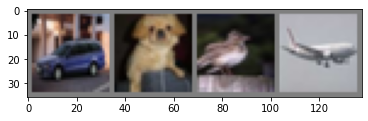

car   dog   bird  plane


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [4]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12,kernel_size=(5,5))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(5,5))
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
       



    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = NN()
        

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print(optimizer)


SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Training of the network

In [6]:
from torch.profiler import profile, record_function, ProfilerActivity

running_loss = 0.0
total = 0.0
correct = 0.0
loss_nodr =[]
acc_nodr = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in range(10):
    
    print('epoch:', epoch)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad(True)
        with torch.set_grad_enabled(True):
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
             outputs = net(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 2000 == 1999:
            loss_temp = running_loss / 2000
            acc_temp = 100 * correct / total
            loss_nodr.append(loss_temp)
            acc_nodr.append(acc_temp)
            print(
                f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp:.3f} acc: {acc_temp:.3f}')
            running_loss = 0.0
            correct = 0.0
            total = 0.0
print('Finished Training')


epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 2.156 acc: 19.950
[1,  4000] loss: 1.808 acc: 33.212
[1,  6000] loss: 1.659 acc: 38.825
[1,  8000] loss: 1.563 acc: 43.038
[1, 10000] loss: 1.473 acc: 45.837
[1, 12000] loss: 1.422 acc: 49.038
epoch: 1
[2,  2000] loss: 1.720 acc: 50.020
[2,  4000] loss: 1.343 acc: 51.850
[2,  6000] loss: 1.325 acc: 52.362
[2,  8000] loss: 1.269 acc: 54.075
[2, 10000] loss: 1.248 acc: 56.025
[2, 12000] loss: 1.234 acc: 56.288
epoch: 2
[3,  2000] loss: 1.479 acc: 58.210
[3,  4000] loss: 1.163 acc: 58.775
[3,  6000] loss: 1.171 acc: 58.825
[3,  8000] loss: 1.142 acc: 59.600
[3, 10000] loss: 1.126 acc: 60.025
[3, 12000] loss: 1.144 acc: 59.975
epoch: 3
[4,  2000] loss: 1.350 acc: 60.990
[4,  4000] loss: 1.072 acc: 62.362
[4,  6000] loss: 1.069 acc: 62.138
[4,  8000] loss: 1.062 acc: 62.212
[4, 10000] loss: 1.034 acc: 63.900
[4, 12000] loss: 1.040 acc: 63.462
epoch: 4
[5,  2000] loss: 1.228 acc: 65.810
[5,  4000] loss: 0.979 acc: 65.925
[5,  6000] loss: 0.966 acc: 66.112
[5,  8000] loss: 0.

In [7]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::conv2d         0.39%      11.000us        62.14%       1.756ms     878.000us             2  
                aten::convolution         1.34%      38.000us        61.75%       1.745ms     872.500us             2  
               aten::_convolution         0.78%      22.000us        60.40%       1.707ms     853.500us             2  
         aten::mkldnn_convolution        58.70%       1.659ms        59.62%       1.685ms     842.500us             2  
                 aten::max_pool2d         0.35%      10.000us        22.86%     646.000us     323.000us             2  
    aten::max_pool2d_with_indices       

In [9]:
from torch.profiler import profile, record_function, ProfilerActivity

running_loss = 0.0
total = 0.0
correct = 0.0
loss_nodr = []
acc_nodr = []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in range(5):

    print('epoch:', epoch)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
            outputs = net(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 2000 == 1999:
            loss_temp = running_loss / 2000
            acc_temp = 100 * correct / total
            loss_nodr.append(loss_temp)
            acc_nodr.append(acc_temp)
            print(
                f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp:.3f} acc: {acc_temp:.3f}')
            running_loss = 0.0
            correct = 0.0
            total = 0.0
print('Finished Training')


epoch: 0
[1,  2000] loss: 0.840 acc: 69.888
[1,  4000] loss: 0.849 acc: 69.900
[1,  6000] loss: 0.870 acc: 69.088
[1,  8000] loss: 0.841 acc: 70.312
[1, 10000] loss: 0.858 acc: 70.100
[1, 12000] loss: 0.860 acc: 69.750
epoch: 1
[2,  2000] loss: 1.050 acc: 70.090
[2,  4000] loss: 0.865 acc: 69.625
[2,  6000] loss: 0.853 acc: 70.037
[2,  8000] loss: 0.865 acc: 69.037
[2, 10000] loss: 0.847 acc: 69.950
[2, 12000] loss: 0.860 acc: 69.650
epoch: 2
[3,  2000] loss: 1.047 acc: 70.210
[3,  4000] loss: 0.865 acc: 69.138
[3,  6000] loss: 0.856 acc: 69.938
[3,  8000] loss: 0.861 acc: 69.787
[3, 10000] loss: 0.856 acc: 69.812
[3, 12000] loss: 0.834 acc: 70.713
epoch: 3
[4,  2000] loss: 1.084 acc: 68.850
[4,  4000] loss: 0.853 acc: 69.275
[4,  6000] loss: 0.843 acc: 70.263
[4,  8000] loss: 0.862 acc: 69.763
[4, 10000] loss: 0.856 acc: 69.688
[4, 12000] loss: 0.849 acc: 70.263
epoch: 4
[5,  2000] loss: 1.064 acc: 70.520
[5,  4000] loss: 0.884 acc: 68.500
[5,  6000] loss: 0.848 acc: 69.562
[5,  8000]

In [219]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::conv2d         0.84%      10.000us        56.81%     676.000us     338.000us             2  
                aten::convolution         3.36%      40.000us        55.97%     666.000us     333.000us             2  
               aten::_convolution         2.10%      25.000us        52.61%     626.000us     313.000us             2  
         aten::mkldnn_convolution        48.99%     583.000us        50.50%     601.000us     300.500us             2  
                     aten::linear         1.26%      15.000us        17.65%     210.000us      70.000us             3  
                 aten::max_pool2d       

In [13]:
path = './cifar_net.pt'


In [14]:
torch.save(net.state_dict(), path)

In [15]:
get_model = NN()
get_model.load_state_dict(torch.load(path))
get_model.eval()


NN(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

NN(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


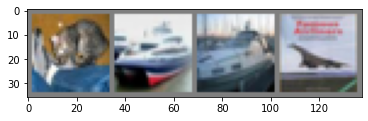

cat
ship
ship
plane


In [32]:
test_data = iter(testloader)
images_test, labels_test = test_data.next()


imshow(torchvision.utils.make_grid(images_test))

for a in labels_test:
    print(classes[a])

In [33]:
net.load_state_dict(get_model.state_dict())

<All keys matched successfully>

In [34]:
the_output = net(images_test)

acc, lb_pred = torch.max(the_output, 1)
print(lb_pred)



tensor([3, 8, 1, 8])


In [35]:
for i in lb_pred:
    print('Predicted: {}'.format(classes[i]))


Predicted: cat
Predicted: ship
Predicted: car
Predicted: ship


In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 58 %


In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 48.5 %
Accuracy for class: car   is 80.3 %
Accuracy for class: bird  is 37.5 %
Accuracy for class: cat   is 19.5 %
Accuracy for class: deer  is 39.8 %
Accuracy for class: dog   is 67.9 %
Accuracy for class: frog  is 76.2 %
Accuracy for class: horse is 52.7 %
Accuracy for class: ship  is 71.9 %
Accuracy for class: truck is 65.4 %


In [154]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cpu


In [155]:
inputs, labels = data[0].to(device), data[1].to(device)


In [196]:
for name, params in net.named_parameters():
    print(name, params.shape)

conv1.weight torch.Size([12, 3, 5, 5])
conv1.bias torch.Size([12])
conv2.weight torch.Size([16, 12, 5, 5])
conv2.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


In [71]:
weight_param = []

for idx, (name, params) in enumerate(net.named_parameters()):
    
    if 'weight' in name:
        print(name)
        print(params.shape)
        weight_param.append((name, params))
        print('the shape: ', params.shape) 

conv1.weight
torch.Size([12, 3, 5, 5])
the shape:  torch.Size([12, 3, 5, 5])
conv2.weight
torch.Size([16, 12, 5, 5])
the shape:  torch.Size([16, 12, 5, 5])
fc1.weight
torch.Size([120, 400])
the shape:  torch.Size([120, 400])
fc2.weight
torch.Size([84, 120])
the shape:  torch.Size([84, 120])
fc3.weight
torch.Size([10, 84])
the shape:  torch.Size([10, 84])


In [101]:
#define dictionery to store dimensionally reduced wegith matrices

dr_dic = {}

In [102]:
#convolution layer dimensional reduction
nam, par = weight_param[0]
par = par.detach().numpy()
par = par.reshape([36,-1])
par = par.T
n_components = par.shape[0]
n_features = par.shape[1]
print('param:', par.shape)
min_value = min(n_features, n_components)
x_pca = dec.PCA(n_components=int(min_value-1))
x_pca.fit(par)
dr_small = x_pca.transform(par)
print('dimensionaly reduced weights', dr_small.shape)
dr_small = dr_small.T
dr_small = dr_small.reshape([-1,3,5,5])
print('new shape given: ', dr_small.shape )
dr_dic[nam] = torch.tensor(dr_small)




param: (25, 36)
dimensionaly reduced weights (25, 24)
new shape given:  (8, 3, 5, 5)


In [103]:

nam, par = weight_param[1]
par = par.detach().numpy()
print('param:', par.shape)
new_dim = par.reshape([80,-1])
new_dim = new_dim.T
n_components = new_dim.shape[0]
n_features = new_dim.shape[1]
min_value = min(n_features, n_components)
print(new_dim.shape)
x_pca = dec.PCA(n_components=int(min_value-20))
x_pca.fit(new_dim)
dr_small = x_pca.transform(new_dim)
print('dimensionaly reduced weights', dr_small.shape)
dr_small = dr_small.T
dr_small = dr_small.reshape([-1, 8, 5, 5])
print('new shape given: ', dr_small.shape)
dr_dic[nam] = torch.tensor(dr_small)




param: (16, 12, 5, 5)
(60, 80)
dimensionaly reduced weights (60, 40)
new shape given:  (12, 8, 5, 5)


In [104]:
nam, par = weight_param[2]
par = par.detach().numpy()

par = par.reshape(-1,300)
par = par.T
n_components= par.shape[0]
n_features = par.shape[1]
print('param:', par.shape)
min_value  = min(n_features, n_components)
x_pca = dec.PCA(n_components=int(min_value-40))
x_pca.fit(par)
dr_small = x_pca.transform(par)

x2_pca = dec.PCA(n_components=60)

x2_pca.fit(dr_small)
dr_small = x2_pca.transform(dr_small)
    
dr_small = dr_small.T

print('reduced dimenaion:', dr_small.shape)
dr_dic[nam] = torch.tensor(dr_small)
#---------------------

nam, par = weight_param[3]
par = par.detach().numpy()
par = par.T
par = par.reshape(dr_small.shape[0], -1)

n_components = par.shape[0]
n_features = par.shape[1]
print('param:', par.shape)
min_value = min(n_features, n_components)
x_pca_2 = dec.PCA(n_components=int(168/3))
x_pca_2.fit(par)
dr_small_2 = x_pca_2.transform(par)

dr_small_2 = dr_small_2.T

print('reduced dimenaion:', dr_small_2.shape)
dr_dic[nam] = torch.tensor(dr_small_2)


nam, par = weight_param[4]
par = par.detach().numpy()
par = par.T
par = par.reshape(dr_small_2.shape[0], -1)

n_components = par.shape[0]
n_features = par.shape[1]
print('param:', par.shape)
min_value = min(n_features, n_components)
x_pca_3 = dec.PCA(n_components=int(min_value-5))
x_pca_3.fit(par)
dr_small_3 = x_pca_3.transform(par)

dr_small_3 = dr_small_3.T

print('reduced dimenaion:', dr_small_3.shape)
dr_dic[nam] = torch.tensor(dr_small_3)


param: (300, 160)
reduced dimenaion: (60, 300)
param: (60, 168)
reduced dimenaion: (56, 60)
param: (56, 15)
reduced dimenaion: (10, 56)


In [84]:
dr_dic['fc1.weight'] = dr_dic['fc1.weight'].T
print(dr_dic['fc1.weight'].shape)
dr_dic['fc2.weight'] = dr_dic['fc2.weight'].T
print(dr_dic['fc2.weight'].shape)

dr_dic['fc3.weight'] = dr_dic['fc3.weight'].T
print(dr_dic['fc3.weight'].shape)


torch.Size([60, 300])
torch.Size([56, 60])
torch.Size([10, 56])


In [105]:
#changing input and output matrix for neural network



for idx ,(name, params) in enumerate(dr_dic.items()):
        print(dr_dic[name].shape)




torch.Size([8, 3, 5, 5])
torch.Size([12, 8, 5, 5])
torch.Size([60, 300])
torch.Size([56, 60])
torch.Size([10, 56])


In [109]:
dr_dic = {}
for idx, (key, value) in enumerate(weight_param.items()):

    if idx == 0:
        continue

    x = weight_param[key].detach().numpy()
    
    isDimBig = len(x.shape) > 2
    if isDimBig:
        dim3 = x.shape[2]
        dim4 = x.shape[3]
        x = x.reshape(-1, dim3 * dim4)

    print('before reshaping:', x.shape)

    arb = 100
    if x.shape[0] < x.shape[1] and x.shape[0] <= arb:
     dim = int(x.shape[1]/2)
     x = x.reshape((-1, dim))
    x = x.T
    print('after reshaping:', x.shape)
    n_components= x.shape[0]
    n_features = x.shape[1]

    small_pca = dec.PCA(n_components=int(n_features-20))
    small_pca.fit(x)
    dr_small = small_pca.transform(x)

    if isDimBig:
        dr_small = dr_small.reshape(-1,  dim3,  dim4)

    print('dmiensional reduction PCA', dr_small.shape)
    dr_small = dr_small.T
    print('Transpose', dr_small.shape)
    


    # i = key.split('.')
    # i = int(i[0])
    dr_dic[key] = torch.tensor(dr_small)
    # net[i].weight = nn.Parameter(torch.tensor(dr_small))
    # seq_modules[i] = nn.Linear(in_features=dr_small.shape[1],
    #                    out_features=dr_small.shape[0], bias=True)

    print('Assigned value to network weight', dr_dic[key].shape)
    # print('Module', net[i])
    print('----------------------------------------')



AttributeError: 'list' object has no attribute 'items'

In [106]:
net.state_dict = dr_dic


In [107]:
for key in dr_dic:
    print(key)

conv1.weight
conv2.weight
fc1.weight
fc2.weight
fc3.weight


BIAS MODIFICATION 

In [108]:
bias_n = net.conv1.bias
bias_n = bias_n.detach().numpy()
bias_n = bias_n.reshape(4, 3)
print(bias_n.shape)

lol = dec.PCA(n_components=2)
lol.fit(bias_n)
aa = lol.transform(bias_n)
aa = aa.flatten()
net.conv1.bias = nn.Parameter(torch.tensor(aa))
print('net bias updated:', net.conv1.bias.shape)


ValueError: cannot reshape array of size 8 into shape (4,3)

In [96]:
bias_n = net.conv2.bias
bias_n = bias_n.detach().numpy()
bias_n = bias_n.reshape(4, 4)
print(bias_n.shape)

lol = dec.PCA(n_components=3)
lol.fit(bias_n)
aa = lol.transform(bias_n)
aa = aa.flatten()
net.conv2.bias = nn.Parameter(torch.tensor(aa))
print('net bias updated:', net.conv2.bias.shape)


(4, 4)
net bias updated: torch.Size([12])


In [90]:
bias_n = net.fc1.bias
bias_n = bias_n.detach().numpy()
bias_n = bias_n.reshape(12,-1)
print(bias_n.shape)

lol = dec.PCA(n_components=5)
lol.fit(bias_n)
aa = lol.transform(bias_n)
aa = aa.flatten()
net.fc1.bias =  nn.Parameter(torch.tensor(aa))
print('net bias updated:', net.fc1.bias.shape)





(12, 10)
net bias updated: torch.Size([60])


In [91]:
bias_n = net.fc2.bias
bias_n = bias_n.detach().numpy()
bias_n = bias_n.reshape(14, -1)
print(bias_n.shape)

lol = dec.PCA(n_components=4)
lol.fit(bias_n)
aa = lol.transform(bias_n)
aa = aa.flatten()
net.fc2.bias = nn.Parameter(torch.tensor(aa))
print('net bias updated:', net.fc2.bias.shape)


(14, 6)
net bias updated: torch.Size([56])


In [109]:
#conv layer
conv1 = dr_dic['conv1.weight']
conv2 = dr_dic['conv2.weight']
net.conv1.weight = torch.nn.Parameter(conv1)

# net.conv1 = nn.Conv2d(in_channels=conv1.shape[1], out_channels=conv1.shape[0], 
# kernel_size=(conv1.shape[2], conv1.shape[3]))

net.conv2.weight = torch.nn.Parameter(conv2)

# net.conv2 = nn.Conv2d(in_channels=conv2.shape[1], out_channels=conv2.shape[0], 
# kernel_size=(conv2.shape[2], conv2.shape[3]))


In [110]:
net.fc1.weight = torch.nn.Parameter(dr_dic['fc1.weight'])

# net.fc1 = nn.Linear(in_features=net.fc1.weight.shape[1], out_features=net.fc1.weight.shape[0])

net.fc2.weight = torch.nn.Parameter(dr_dic['fc2.weight'])

# net.fc2 = nn.Linear(in_features=net.fc2.weight.shape[1], out_features=net.fc2.weight.shape[0])


net.fc3.weight = torch.nn.Parameter(dr_dic['fc3.weight'])

# net.fc3 = nn.Linear(in_features=net.fc3.weight.shape[1], out_features=net.fc3.weight.shape[0])





print(net.eval)

<bound method Module.eval of NN(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>


In [111]:
# print the parameter shapes of the model

for n, p in net.named_parameters():
    print('name: ', n, '            parameter: ', p.shape)


name:  conv1.weight             parameter:  torch.Size([8, 3, 5, 5])
name:  conv1.bias             parameter:  torch.Size([8])
name:  conv2.weight             parameter:  torch.Size([12, 8, 5, 5])
name:  conv2.bias             parameter:  torch.Size([12])
name:  fc1.weight             parameter:  torch.Size([60, 300])
name:  fc1.bias             parameter:  torch.Size([60])
name:  fc2.weight             parameter:  torch.Size([56, 60])
name:  fc2.bias             parameter:  torch.Size([56])
name:  fc3.weight             parameter:  torch.Size([10, 56])
name:  fc3.bias             parameter:  torch.Size([10])


TESTING NETWORK WITH DIMEMSNIOALLY REDUCED NETWORK 

In [112]:
print(net.conv1.bias.shape)


print(net(images_test).shape)

torch.Size([8])
torch.Size([4, 10])


In [113]:
the_output = net(images_test)

acc, lb_pred = torch.max(the_output, 1)
print(lb_pred)


tensor([4, 7, 1, 4])


In [116]:
for i in lb_pred:
    print('Predicted: {}'.format(classes[i]))


Predicted: deer
Predicted: horse
Predicted: car
Predicted: deer


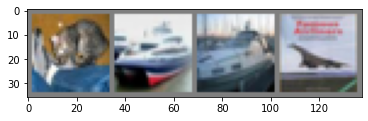

cat
ship
ship
plane


In [115]:

imshow(torchvision.utils.make_grid(images_test))

for a in labels_test:
    print(classes[a])


In [150]:
loss_dr = []
acc_dr = []

running_loss = 0.0
total = 0.0
correct = 0.0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in range(5):
    
    print('epoch:', epoch)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad(True)
        with torch.set_grad_enabled(True):
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
             outputs = net(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 2000 == 1999:
            loss_temp = running_loss / 2000
            acc_temp = 100 * correct / total
            loss_nodr.append(loss_temp)
            acc_nodr.append(acc_temp)
            print(
                f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp:.3f} acc: {acc_temp:.3f}')
            running_loss = 0.0
            correct = 0.0
            total = 0.0
print('Finished Training')


epoch: 0


c:\Users\sulta\anaconda3\lib\site-packages\torch\autograd\profiler.py:160: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[1,  2000] loss: 2.304 acc: 10.475
[1,  4000] loss: 2.304 acc: 9.775
[1,  6000] loss: 2.303 acc: 10.025
[1,  8000] loss: 2.303 acc: 9.975
[1, 10000] loss: 2.304 acc: 9.925
[1, 12000] loss: 2.303 acc: 10.262
epoch: 1
[2,  2000] loss: 2.880 acc: 9.610
[2,  4000] loss: 2.304 acc: 9.863
[2,  6000] loss: 2.304 acc: 9.925
[2,  8000] loss: 2.304 acc: 10.387
[2, 10000] loss: 2.304 acc: 9.975
[2, 12000] loss: 2.304 acc: 10.050
epoch: 2
[3,  2000] loss: 2.880 acc: 10.530
[3,  4000] loss: 2.304 acc: 9.812
[3,  6000] loss: 2.304 acc: 9.800
[3,  8000] loss: 2.303 acc: 10.375
[3, 10000] loss: 2.303 acc: 9.925
[3, 12000] loss: 2.303 acc: 9.975
epoch: 3
[4,  2000] loss: 2.878 acc: 9.980
[4,  4000] loss: 2.305 acc: 9.775
[4,  6000] loss: 2.303 acc: 9.850
[4,  8000] loss: 2.304 acc: 9.950
[4, 10000] loss: 2.304 acc: 9.925
[4, 12000] loss: 2.303 acc: 10.650
epoch: 4
[5,  2000] loss: 2.880 acc: 9.690
[5,  4000] loss: 2.304 acc: 10.262
[5,  6000] loss: 2.303 acc: 9.713
[5,  8000] loss: 2.304 acc: 10.475
[5

In [117]:
loss_dr = []
acc_dr = []
for epoch in range(5):
    running_loss = 0.0
    print('epoch:', epoch)
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 2000 == 1999:
            ac = 100 * correct / total
            acc_dr.append(ac)
            loss_temp_dr = running_loss / 2000
            loss_dr.append(loss_temp_dr)

            print(
                f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp_dr:.3f} acc: {ac:.3f}')
            running_loss = 0.0
            correct = 0.0
            total = 0.0
print('Finished Training')


epoch: 0
[1,  2000] loss: 13.948 acc: 22.450
[1,  4000] loss: 12.538 acc: 10.238
[1,  6000] loss: 12.007 acc: 10.713
[1,  8000] loss: 11.817 acc: 9.963
[1, 10000] loss: 11.785 acc: 9.300
[1, 12000] loss: 11.686 acc: 10.275
epoch: 1
[2,  2000] loss: 11.747 acc: 9.820
[2,  4000] loss: 11.731 acc: 10.338
[2,  6000] loss: 11.547 acc: 10.188
[2,  8000] loss: 11.528 acc: 10.600
[2, 10000] loss: 11.777 acc: 10.188
[2, 12000] loss: 11.682 acc: 9.463
epoch: 2
[3,  2000] loss: 11.549 acc: 10.090
[3,  4000] loss: 11.763 acc: 9.912
[3,  6000] loss: 11.543 acc: 9.975
[3,  8000] loss: 11.667 acc: 9.700
[3, 10000] loss: 11.798 acc: 10.325
[3, 12000] loss: 11.626 acc: 10.600
epoch: 3
[4,  2000] loss: 11.627 acc: 10.420
[4,  4000] loss: 11.674 acc: 10.188
[4,  6000] loss: 11.719 acc: 9.613
[4,  8000] loss: 11.585 acc: 10.125
[4, 10000] loss: 11.626 acc: 10.250
[4, 12000] loss: 11.603 acc: 10.512
epoch: 4
[5,  2000] loss: 11.657 acc: 9.530
[5,  4000] loss: 11.822 acc: 10.325
[5,  6000] loss: 11.577 acc:

In [238]:
loss_dr = []
acc_dr = []
for epoch in range(10):
    running_loss = 0.0
    print('epoch:', epoch)
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = input.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
                outputs = net(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % 2000 == 1999:
            ac = 100 * correct / total
            acc_dr.append(ac)
            loss_temp_dr = running_loss / 2000
            loss_dr.append(loss_temp_dr)

            print(
                f'[{epoch + 1}, {i + 1:5d}] loss: {loss_temp_dr:.3f} acc: {ac:.3f}')
            running_loss = 0.0
            correct = 0.0
            total = 0.0
print('Finished Training')

epoch: 0
[1,  2000] loss: 2.301 acc: 21.660
[1,  4000] loss: 2.257 acc: 13.725
[1,  6000] loss: 2.209 acc: 16.488
[1,  8000] loss: 2.176 acc: 18.475
[1, 10000] loss: 2.143 acc: 19.538
[1, 12000] loss: 2.123 acc: 20.212
epoch: 1
[2,  2000] loss: 2.098 acc: 21.810
[2,  4000] loss: 2.068 acc: 24.062
[2,  6000] loss: 2.058 acc: 24.812
[2,  8000] loss: 2.028 acc: 26.675
[2, 10000] loss: 2.012 acc: 26.712
[2, 12000] loss: 1.994 acc: 28.587
epoch: 2
[3,  2000] loss: 1.980 acc: 28.810
[3,  4000] loss: 1.978 acc: 28.938
[3,  6000] loss: 1.959 acc: 29.363
[3,  8000] loss: 1.950 acc: 29.850
[3, 10000] loss: 1.952 acc: 30.225
[3, 12000] loss: 1.938 acc: 30.837
epoch: 3
[4,  2000] loss: 1.917 acc: 31.790
[4,  4000] loss: 1.926 acc: 31.413
[4,  6000] loss: 1.907 acc: 31.837
[4,  8000] loss: 1.905 acc: 31.712
[4, 10000] loss: 1.907 acc: 31.650
[4, 12000] loss: 1.888 acc: 33.663
epoch: 4
[5,  2000] loss: 1.889 acc: 32.930
[5,  4000] loss: 1.878 acc: 33.538
[5,  6000] loss: 1.867 acc: 33.862
[5,  8000]

In [107]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                     aten::conv2d         0.72%       8.000us        49.55%     551.000us     275.500us             2  
                aten::convolution         2.79%      31.000us        48.83%     543.000us     271.500us             2  
               aten::_convolution         1.80%      20.000us        46.04%     512.000us     256.000us             2  
         aten::mkldnn_convolution        42.81%     476.000us        44.24%     492.000us     246.000us             2  
                 aten::max_pool2d        13.31%     148.000us        23.65%     263.000us     131.500us             2  
                     aten::linear       

In [42]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 62 %


In [125]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 76.9 %
Accuracy for class: truck is 26.8 %


In [82]:
import time
import os
import copy


correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

            # Iterate over data.
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

                # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = net(inputs)
                _,prediction = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    running_corrects += torch.sum(label.data)
                

            running_loss += loss.item()
            
            scheduler.step()
            if i%2000 ==1999:
                epoch_loss = running_loss / 2000
                epoch_acc = 100 * running_corrects.double() / len(trainset)
                print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if  epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict)

            


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [83]:
from torch.optim import lr_scheduler

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [84]:
new_model  = train_model(net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Loss: 0.4194 Acc: 6.5000
Loss: 0.8207 Acc: 13.1020
Loss: 1.2304 Acc: 19.5340
Loss: 1.6373 Acc: 26.0780
Loss: 2.0417 Acc: 32.4460
Loss: 2.4456 Acc: 39.0560

Epoch 1/24
----------
Loss: 0.4175 Acc: 6.1420
Loss: 0.8159 Acc: 12.6200
Loss: 1.1991 Acc: 19.1060
Loss: 1.6107 Acc: 25.7280
Loss: 2.0123 Acc: 32.5820
Loss: 2.4282 Acc: 39.0280

Epoch 2/24
----------
Loss: 0.4189 Acc: 6.2880
Loss: 0.8227 Acc: 12.7560
Loss: 1.2354 Acc: 19.4260
Loss: 1.6417 Acc: 26.0760
Loss: 2.0308 Acc: 32.2640
Loss: 2.4357 Acc: 38.6800

Epoch 3/24
----------
Loss: 0.4098 Acc: 6.2440
Loss: 0.8125 Acc: 12.5440
Loss: 1.2265 Acc: 18.9260
Loss: 1.6339 Acc: 25.4480
Loss: 2.0226 Acc: 31.8760
Loss: 2.4346 Acc: 38.1440

Epoch 4/24
----------
Loss: 0.3934 Acc: 6.4180
Loss: 0.7992 Acc: 12.6280
Loss: 1.2262 Acc: 19.2140
Loss: 1.6196 Acc: 25.5520
Loss: 2.0319 Acc: 31.7300
Loss: 2.4397 Acc: 38.4240

Epoch 5/24
----------
Loss: 0.4179 Acc: 6.4360
Loss: 0.8154 Acc: 12.4300
Loss: 1.2205 Acc: 18.8200


KeyboardInterrupt: 